# Real time $R_t$ estimation
Daniele Proverbio - LCSB - 2020-05-09.  

The basic reproduction number [$R_0$](https://en.wikipedia.org/wiki/Basic_reproduction_number) quantifies the potential strength of an epidemic outbreak, at the very beginning of a pandemic. During the epidemic evolution, we can further estimate the time-dependent effective reproduction number [$R_t$](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory), to have a quantitative probe of its severity. This is also useful for cross-country comparison.  
The algorithm we use is based on [Kevin Systrom's](https://github.com/k-sys/covid-19) - April 17. It is consistent with the one from Mathematical Modelling of Infectious Disases, London School of Hygiene and Tropical Medicine ([link](https://epiforecasts.io/covid/contributors.html)). Here, we adapted it for Luxembourg, with updated stream flow for estimation and plotting. Given the latest literature, [serial interval](https://en.wikipedia.org/wiki/Serial_interval) for COVID-19 is [about 4 days](https://www.jwatch.org/na51171/2020/03/27/serial-interval-covid-19). We also implement a simple [nowcasting](https://en.wikipedia.org/wiki/Nowcasting_(economics)) procedure (idea: Andreas Husch - LCSB).  

Note: during [COVID-19](https://en.wikipedia.org/wiki/Coronavirus_disease_2019) pandemics, there is a delay from infection to detection during to latency, sampling times and so on. Hence, it is necessary to refer all data to their true infection time. Here, we assume constant shift. By comparison with more advanced nowcasting procedures (e.g. RKI's), we estimated such shift to be equal 8±1 days. Hence, be aware that we are looking at the past. This is considered in plots below.

In [19]:
# preliminary setting

import pandas as pd
import numpy as np
import datetime as DT

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = ['LU']

%config InlineBackend.figure_format = 'retina'

#-----

state_name = 'LU'
today = DT.datetime.now().strftime("%Y%m%d")

# prepare data, to get daily cases and smoothing
def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,    #7 days moving window for smoothing
        #win_type='gaussian',   #or comment whole line to have uniform
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed


#----

# getting highest density intervals
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


#-----

# getting posteriors for R_t evaluation
def get_posteriors(sr, date, sigma=0.15):

    # (1) Calculate Lambda
    gamma=1/np.random.normal(4, 0.2, len(r_t_range))
    lam = sr[:-1] * np.exp(gamma[:, None] * (r_t_range[:, None] - 1))
    #lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:], lam),
        index = r_t_range,
        columns = date[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=date,
        data={date[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(date[:-1], date[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood


In [21]:
#load data

path = 'data/data.csv'
states = pd.read_csv(path,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

In [23]:
# Prepare data for analysis

cases = states.xs(state_name).rename(f"{state_name} cases")
original, smoothed = prepare_cases(cases)

#convert into array for easier handling
original_array = original.values
smoothed_array = smoothed.values

# dates: what we have in real time are detected of cases, but they refer to infection happened several days ago
# comparing with Nowcasting procedures, this latancy is 8±1 days
dates = smoothed.index
dates_detection = date2num(smoothed.index.tolist())
dates_infection = smoothed.index - DT.timedelta(days=9)
dates_infection = date2num(dates_infection.tolist())

In [25]:
#estimate R_t (for detection) and print 

R_T_MAX = 10
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

posteriors, log_likelihood = get_posteriors(smoothed_array, dates, sigma=.15)    #optimal sigma already chosen in original Notebook

# Note that this is not the most efficient algorithm, but works fine
hdis = highest_density_interval(posteriors, p=.5)          # confidence bounds, p=50%

most_likely = posteriors.idxmax().rename('R_t-estimate')   #mean R_t value

result = pd.concat([most_likely, hdis], axis=1)            #global result for R_t-estimate
print(result.tail())

result.to_csv('/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_'+today+'_Rt-estimate.csv')


R_t-estimate  Low_50  High_50
date                                     
2020-05-09          0.65    0.33     0.89
2020-05-10          0.68    0.36     0.93
2020-05-11          0.71    0.37     0.95
2020-05-12          0.70    0.32     0.90
2020-05-13          0.71    0.34     0.93


## "Nowcasting"
Here, we implement TMSNME - The Most Stupid Nowcast Model Ever (conceptualization: Andreas Husch). It simplifies $R_t$ as an exponential fitting between points separated by the serial interval, and use it to extrapolate short-term results.  
We consider 3 possible scenarios, depending on how much lifting measures increase $R_t$ (bias). Scenarios are: no bias, bias =0.1, bias=0.2. These numbers are ad-hoc. Further quantifying the effects of lifting measures on the reproduction number would provide more meaningful input. Note that, by considering the scenarios, the error bound increase for future projections. This asks for cautiono in interpreting extrapolated results (nowcasting).  

We recall that values of today reflect infections of about 8 days ago, so we constantly look at the past.

In [27]:
#print also results for the correct shift in time

result_nowcasted = result.copy()
result_nowcasted.index = result_nowcasted.index - pd.Timedelta(days=8)

result_nowcasted.to_csv('/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_'+today+'_Rt-estimate_nowcast.csv')

In [29]:
#prepare 3 scenarios

smoothed1=smoothed.copy()
smoothed2=smoothed.copy()
smoothed3=smoothed.copy()


posteriors1=posteriors.copy()
posteriors2=posteriors.copy()
posteriors3=posteriors.copy()

log_likelihood1 = log_likelihood.copy()
log_likelihood2 = log_likelihood.copy()
log_likelihood3 = log_likelihood.copy()

hdis1=hdis.copy()
hdis2=hdis.copy()
hdis3=hdis.copy()

most_likely1=most_likely.copy()
most_likely2=most_likely.copy()
most_likely3=most_likely.copy()

result1=result.copy()
result2=result.copy()
result3=result.copy()


In [30]:
# perform "nowcasting"

j=0
while j <8:
    new_date = smoothed1.index[-1]  + pd.Timedelta(days=1)
    smoothed1.loc[new_date]=round((smoothed1.values[-4]*(most_likely1.values[-1]+0)))
    smoothed2.loc[new_date]=round((smoothed2.values[-4]*(most_likely2.values[-1]+0.1)))
    smoothed3.loc[new_date]=round((smoothed3.values[-4]*(most_likely3.values[-1]+0.2)))
    
    j=j+1
    
    posteriors1, log_likelihood1 = get_posteriors(smoothed1.values, smoothed1.index, sigma=.15) 
    hdis1 = highest_density_interval(posteriors1, p=.5)  
    most_likely1 = posteriors1.idxmax().rename('R_t-estimate') 
    result1 = pd.concat([most_likely1, hdis1], axis=1)  
    result1.index = result1.index - pd.Timedelta(days=8)
    
    posteriors2, log_likelihood2 = get_posteriors(smoothed2.values, smoothed2.index, sigma=.15) 
    hdis2 = highest_density_interval(posteriors2, p=.5)  
    most_likely2 = posteriors2.idxmax().rename('R_t-estimate') 
    result2 = pd.concat([most_likely2, hdis2], axis=1) 
    result2.index = result2.index - pd.Timedelta(days=8)
    
    posteriors3, log_likelihood3 = get_posteriors(smoothed3.values, smoothed3.index, sigma=.15) 
    hdis3 = highest_density_interval(posteriors3, p=.5)  
    most_likely3 = posteriors3.idxmax().rename('R_t-estimate') 
    result3 = pd.concat([most_likely3, hdis3], axis=1) 
    result3.index = result3.index - pd.Timedelta(days=8)


In [31]:
#check
result3.tail(10)

,R_t-estimate,Low_50,High_50
date,,,
2020-05-04,0.68,0.33,0.91
2020-05-05,0.72,0.34,0.93
2020-05-06,0.72,0.35,0.95
2020-05-07,0.72,0.35,0.96
2020-05-08,0.79,0.41,1.02
2020-05-09,0.79,0.39,1.01
2020-05-10,0.79,0.44,1.06
2020-05-11,0.79,0.40,1.03
2020-05-12,0.83,0.44,1.07


## Plots

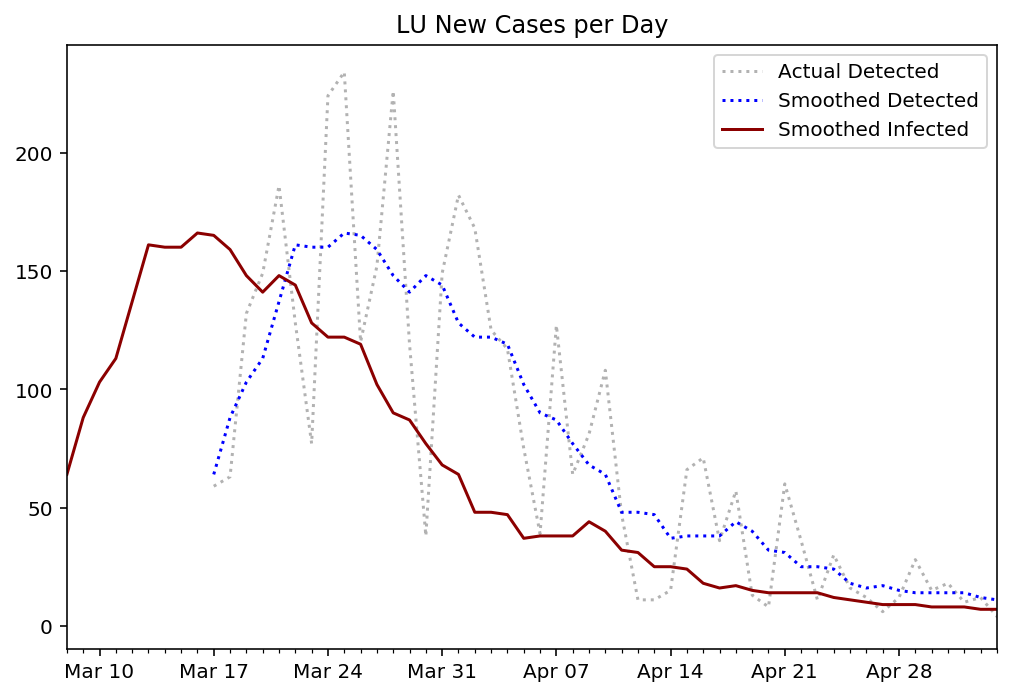

In [32]:
#Plot data

fig, ax = plt.subplots(figsize=(600/72,400/72))
plt.title(f"{state_name} New Cases per Day")
plt.plot_date(dates_detection[2:], original_array[2:],':',alpha=.6,color="grey",label="Actual Detected")
plt.plot_date(dates_detection[2:], smoothed_array[2:],'b:',label="Smoothed Detected")
plt.plot_date(dates_infection[2:], smoothed_array[2:],'-',color="darkred",label="Smoothed Infected")
plt.legend()

ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.set_xlim(dates_infection[2], dates_infection[-1])

fig.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_"+today+"_data.png",bbox_inches = "tight",transparent=True)


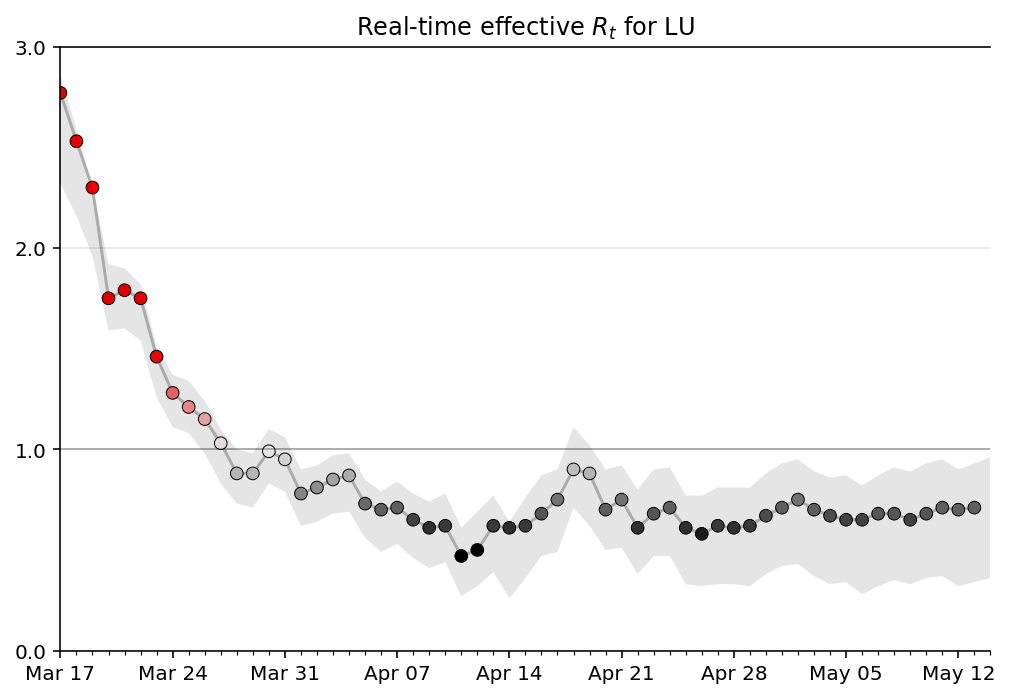

In [33]:
#Plot R_t alone
#Plot only R_t (current)

def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['R_t-estimate'].index.get_level_values('date')
    values = result['R_t-estimate'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_50'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_50'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.spines['right'].set_visible(False)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(result.index.get_level_values('date')[2], result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax2 = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax2, state_name)
ax2.set_title(f'Real-time effective $R_t$ for {state_name}')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

fig.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_"+today+"_Rt.png",bbox_inches = "tight",transparent=True)


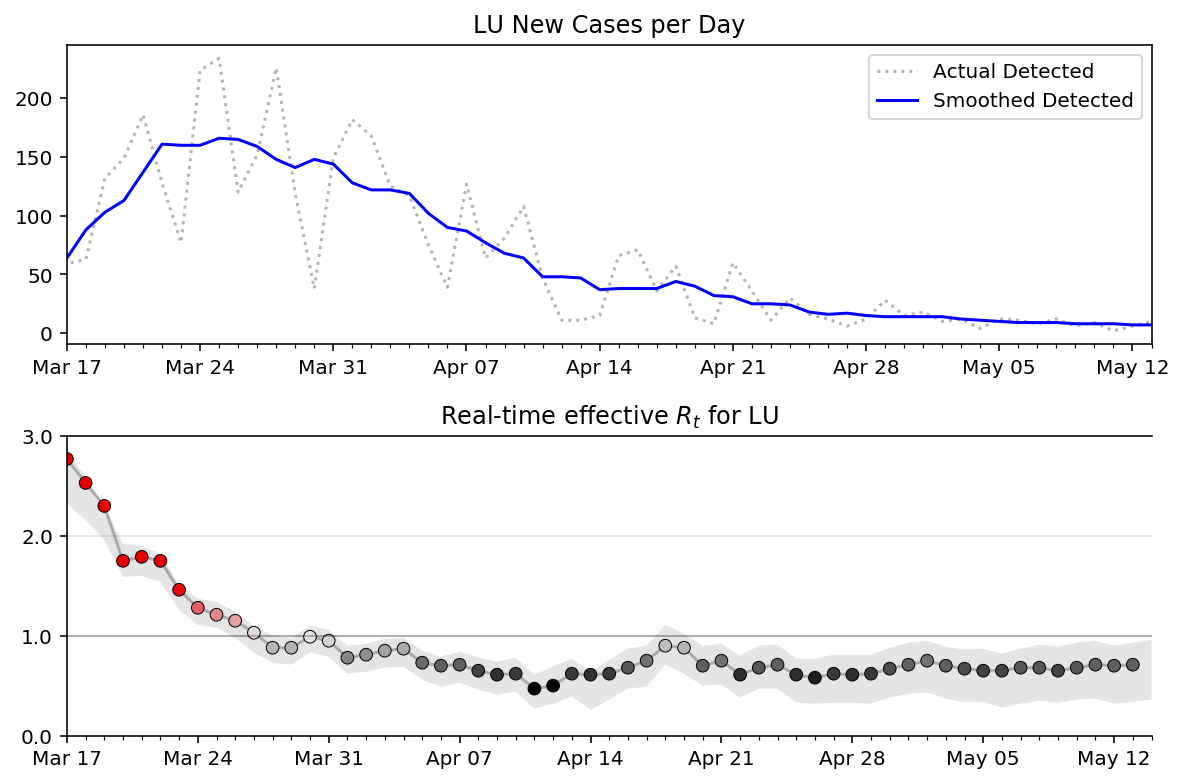

In [34]:
# detected cases, plus R_t

fig, ax = plt.subplots(2,figsize=(600/72,400/72))

#Fig 1
ax[0].set_title(f"{state_name} New Cases per Day")
ax[0].plot_date(dates_detection, original_array,':',alpha=.6,color="grey",label="Actual Detected")
ax[0].plot_date(dates_detection, smoothed_array,'b',label="Smoothed Detected")
#ax[0].plot_date(dates_infection, smoothed_array,'-',color="darkred",label="Smoothed Nowcasted")
ax[0].legend()

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax[0].set_xlim(dates_detection[2], dates_detection[-1])


#Fig 2
plot_rt(result, ax[1], state_name)
ax[1].set_title(f'Real-time effective $R_t$ for {state_name}')
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.tight_layout()

fig.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_"+today+"_both_present.png",bbox_inches = "tight",transparent=True)


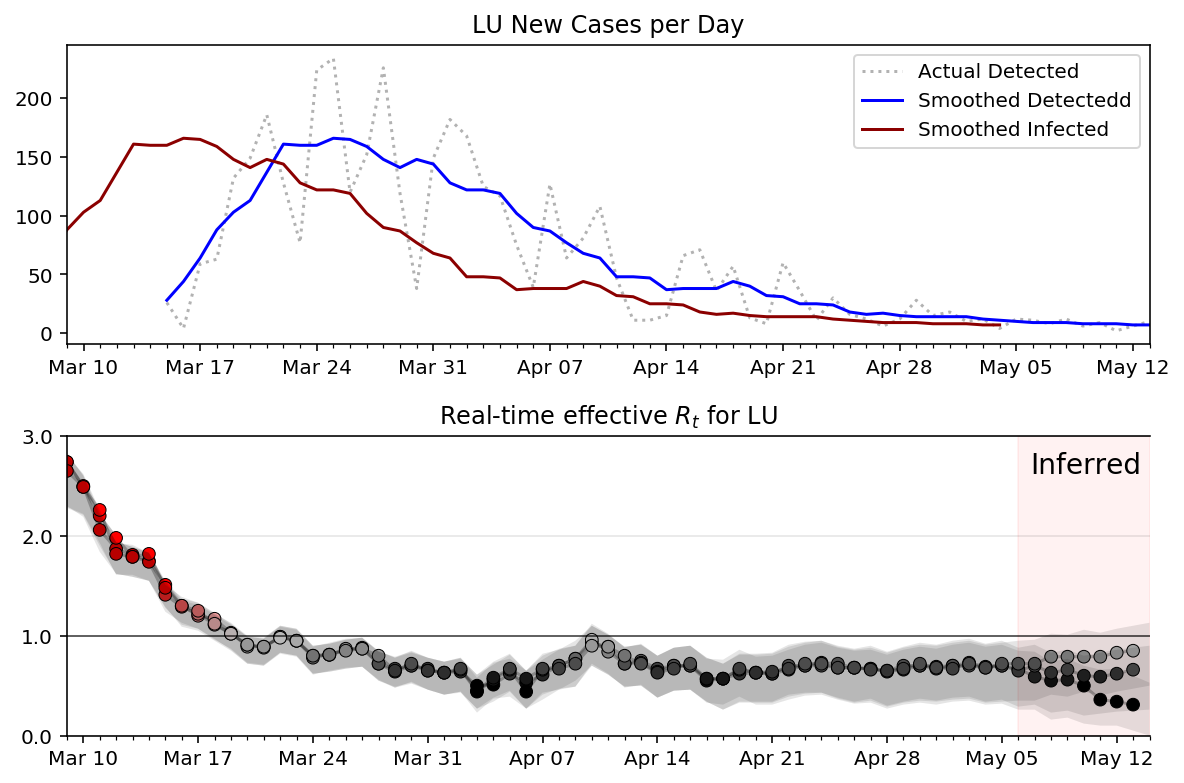

In [35]:
#all together

# detected cases, plus R_t

fig, ax = plt.subplots(2,figsize=(600/72,400/72))

#Fig 1
ax[0].set_title(f"{state_name} New Cases per Day")
ax[0].plot_date(dates_detection, original_array,':',alpha=.6,color="grey",label="Actual Detected")
ax[0].plot_date(dates_detection, smoothed_array,'b',label="Smoothed Detectedd")
ax[0].plot_date(dates_infection, smoothed_array,'-',color="darkred",label="Smoothed Infected")
ax[0].legend()

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax[0].set_xlim(dates_infection[3], dates_detection[-1])

#Fig 2

plot_rt(result1, ax[1], state_name)
plot_rt(result2, ax[1], state_name)
plot_rt(result3, ax[1], state_name)
ax[1].set_title(f'Real-time effective $R_t$ for {state_name}')
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].axvspan(result1.index.get_level_values('date')[-8], result1.index.get_level_values('date')[-1]+pd.Timedelta(days=1), alpha=0.05, color='red')

ax[1].text(0.89, 0.95, "Inferred", transform=ax[1].transAxes, fontsize=14,
        verticalalignment='top')

plt.tight_layout()

fig.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_"+today+"_all.png",bbox_inches = "tight",transparent=True)

